In [1]:
import numpy as np
import pandas as pd
from graphviz import Digraph

In [2]:
def split(X, k, feature):
    """ Split source data (X) into two part depends on threshold (k) and feature.
    """
    Left = X[X[:, feature] <= k]
    Right = X[X[:, feature] > k]
    return Left, Right

In [3]:
def Gini(X):
    """ Compute Gini information criterion of X.
    """
    _, counts = np.unique(X[:, -1], return_counts=True)
    probabilities = counts / len(X)
    impurity = 1 - np.sum(probabilities**2)
    return impurity

In [4]:
def IG_Gini(X, k, feature):
    """ Compute Gini information gain of child nodes.
    """
    Left, Right = split(X, k, feature)
    
    Left_weight = len(Left) / (len(Left) + len(Right))
    Right_weight = 1 - Left_weight
    
    return Gini(X) - (Left_weight * Gini(Left) + Right_weight * Gini(Right))

In [5]:
def get_opt_split(X):
    """ Find optimal split of X by optimal feature and optimal threshold.
    """
    Optk = sorted(np.unique(X[:, 0]))[0]
    num_features = X.shape[1] - 1
    OptFeature = 0
    OptGini = IG_Gini(X, Optk, OptFeature) # we maximize Gini information gain to find optimal

    for feature in range(num_features):
        if feature == 0:
            possible_splits = sorted(np.unique(X[:, feature]))[1:]
        else:
            possible_splits = sorted(np.unique(X[:, feature]))
        for k in possible_splits:
            G = IG_Gini(X, k, feature)

            if G > OptGini:
                OptGini = G
                Optk = k
                OptFeature = feature
    return OptGini, Optk, OptFeature

In [6]:
def build_tree(X, max_depth, current_depth=0, tree=None):
    """ Recursive function to build the decision tree (tree) with max possible depth (max_depth).
        Return: tree as dict            
    """
    if tree is None:
        tree = {}
    
    OptGini, Optk, OptFeature = get_opt_split(X)

    if current_depth == max_depth or OptGini == 0:
        tree['leaf'] = True
        tree['value'] = np.round(np.mean(X[:,-1]))
        return tree

    tree['feature'] = OptFeature
    tree['threshold'] = Optk
    tree['impurity'] = OptGini

    Left, Right = split(X, Optk, OptFeature)

    tree['left'] = {}
    tree['right'] = {}

    build_tree(Left, max_depth, current_depth + 1, tree=tree['left'])
    build_tree(Right, max_depth, current_depth + 1, tree=tree['right'])

    return tree

In [7]:
def predict(tree, X):
    """ Predict label of X.
    """
    if 'leaf' in tree:
        return tree['value']
    else:
        if X[tree['feature']] <= tree['threshold']:
            return predict(tree['left'], X)
        else:
            return predict(tree['right'], X)

In [8]:
def accuracy(tree, data):
    """ Compute accuracy score.
    """
    predictions = [predict(tree, x[:-1]) for x in data]
    actual_labels = data[:, -1]

    correct_predictions = np.sum(predictions == actual_labels)
    total_samples = len(data)

    accuracy = correct_predictions / total_samples
    return accuracy

In [9]:
target_index = {'Kama': 0, 'Rosa': 1, 'Canadian': 2}
df = pd.read_csv('train.csv')
df['Target'] = df['Target'].apply(lambda x: target_index[x])
train = df.to_numpy()
test_df = pd.read_csv('test.csv')
test_df['Target'] = test_df['Target'].apply(lambda x: target_index[x])
test = test_df.to_numpy()

In [10]:
tree = build_tree(train, 4)

In [11]:
tree

{'feature': 6,
 'threshold': 5.533,
 'impurity': 0.32362844127550017,
 'left': {'feature': 0,
  'threshold': 12.7,
  'impurity': 0.4055847202204392,
  'left': {'feature': 5,
   'threshold': 1.415,
   'impurity': 0.041647804436396596,
   'left': {'leaf': True, 'value': 0.0},
   'right': {'leaf': True, 'value': 2.0}},
  'right': {'feature': 5,
   'threshold': 5.234,
   'impurity': 0.11124260355029572,
   'left': {'leaf': True, 'value': 0.0},
   'right': {'feature': 0,
    'threshold': 13.34,
    'impurity': 0.31999999999999984,
    'left': {'leaf': True, 'value': 2.0},
    'right': {'leaf': True, 'value': 0.0}}}},
 'right': {'feature': 0,
  'threshold': 16.63,
  'impurity': 0.012302960399846262,
  'left': {'feature': 0,
   'threshold': 16.53,
   'impurity': 0.4444444444444444,
   'left': {'leaf': True, 'value': 1.0},
   'right': {'leaf': True, 'value': 0.0}},
  'right': {'leaf': True, 'value': 1.0}}}

In [12]:
print(accuracy(tree, train))
print(accuracy(tree, test))

1.0
0.85


In [13]:
# compare our implementation with sklearn implementation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
max_depth = 4
clf = DecisionTreeClassifier(max_depth=max_depth)
clf.fit(train[:,:-1], train[:, -1])
y_pred_1 = clf.predict(train[:,:-1])
y_pred_2 = clf.predict(test[:,:-1])
print(accuracy_score(train[:, -1], y_pred_1))
print(accuracy_score(test[:, -1], y_pred_2))

1.0
0.7333333333333333


In [14]:
def plot_tree(tree, dot=None, parent_name=None, graph=None):
    """ Visualize tree as digraph.
    """
    if dot is None:
        dot = Digraph(comment='Decision Tree')

    if tree.get('feature') is not None:
        node_name = f"Feature {tree['feature']}\nThreshold {tree['threshold']}\nImpurity {round(tree['impurity'], 2)}"
    else:
        node_name = f"Value {tree['value']}"

    dot.node(node_name)

    if parent_name is not None:
        dot.edge(parent_name, node_name)      
        
    for child in ('left', 'right'):
        if child in tree:
            plot_tree(tree[child], dot, node_name, graph=graph)

    return dot

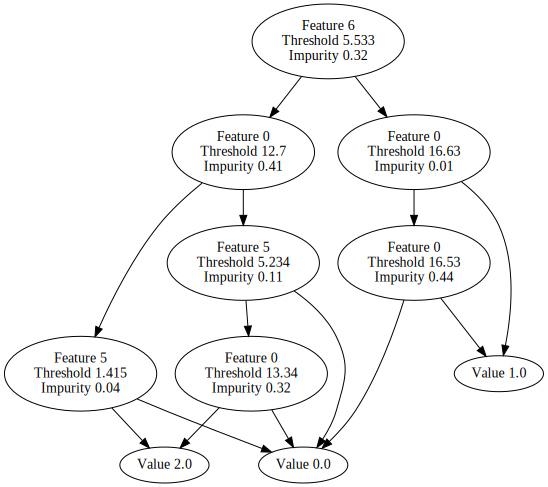

In [15]:
plot_tree(tree)